In [8]:
import stable_baselines3
from raiSimulationEnv2 import RobotSimEnv
import robotic as ry
import numpy as np
import time

In [13]:
#Define simulation functions
C = ry.Config()
C.addFile("rai-robotModels/scenarios/pandasFight.g")
S = ry.Simulation(C, ry.SimulationEngine.physx, verbose=0)
def simulationCloseGrippers(S, tau=0.01):
    S.closeGripper('l_gripper', width=0.0001, speed=0.5)
    while (not S.getGripperIsGrasping('l_gripper')) and (S.getGripperWidth('l_gripper') > 0.001):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        # C.view()
    
    S.closeGripper('r_gripper', width=0.0001, speed=0.5)
    while (not S.getGripperIsGrasping('r_gripper')) and (S.getGripperWidth('r_gripper') > 0.001):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        # C.view()


def simulationOpenGrippers(S, tau=0.01):
    S.openGripper('l_gripper', width=0.05, speed=0.5)
    while S.getGripperWidth('l_gripper') < 0.05 - 0.01:
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        # C.view()
    S.openGripper('r_gripper', width=0.05, speed=0.5)
    while S.getGripperWidth('r_gripper') < 0.05 - 0.01:
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        # C.view()

def simulationGoTo(S, q, tau=0.01, checkCol=False):
    checkColTime = 0.1
    timer = 0
    while np.linalg.norm(S.get_q() - q) > 0.01:
        time.sleep(tau)
        S.step(q, tau, ry.ControlMode.position)
        timer += tau
        # C.view()
        if timer > 4:
            print("Target cannot be reached within 4 seconds.")
            break
        if checkCol:
            if timer > checkColTime:
                if findCollision(C, 'sword_1'):
                    return
                else:
                    checkColTime += 0.1

def simulationGoHome(S, tau=0.01):
    checkColTime = 0.1
    timer = 0
    while np.linalg.norm(S.get_q() - q0) > 0.01:
        time.sleep(tau)
        S.step(q0, tau, ry.ControlMode.position)
        # C.view()
        timer += tau
        # if timer > checkColTime:
        #     if findCollision(C, 'sword_1'):
        #         break
        #     else:
        #         checkColTime += 0.1
            
def simulationFollowPath(S, path, tau=0.01):
    checkColTime = 0.1
    timer = 0
    for i in range(len(path)):
        while np.linalg.norm(S.get_q() - path[i]) > 0.3:
            time.sleep(tau)
            print(i)
            print(np.linalg.norm(S.get_q() - path[i]))
            S.step(path[i], tau, ry.ControlMode.position)
            #C.view()
            timer += tau
            if timer > checkColTime:
                print('check_col')
                if findCollision(C, 'sword_1'):
                    return
                else:
                    checkColTime += 0.1

    simulationGoTo(S, path[-1], checkCol=True)

def simulationWait(S, t, tau=0.01):
    for k in range(int(t / tau)):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        #C.view()

def simulationTorqueCtrl(S, t, torque, tau=0.01):
    for k in range(int(t / tau)):
        time.sleep(tau)
        S.step(torque, tau, ry.ControlMode.acceleration)
        #C.view()

def simulationVelocityCtrl(S,t,vel,tau=0.01):
    for k in range(int(t/tau)):
        time.sleep(tau)
        S.step(vel,tau,ry.ControlMode.velocity)
        #C.view()

def followInterpolatedPath(S,path,tau=0.01):
    checkColTime = 0.1
    timer = 0
    for i in range(len(path)):
        time.sleep(tau)
        print(i)
        print(np.linalg.norm(S.get_q()- path[i]))
        S.step(path[i],tau,ry.ControlMode.position)
        #C.view()
        timer += tau
        if timer > checkColTime:
            if findCollision(C,'sword_1'):
                return
            else:
                checkColTime += 0.1
    simulationGoTo(S,path[-1],checkCol=True)

def findCollision(C,object1):
    collisions = [col for col in C.getCollisions(0) if object1 in col and not col[1].startswith('l_') and not col[0].startswith('l_')]
    if len(collisions) > 0:
        return True
    else:
        return False
    
# Use this code. It is awesome. It will follow the path and stop if there is a collision.    
def followSplinePath(S,C,path,t,tau=0.01):
    """
        Guides a simulation object along a specified spline path.
        Parameters:
        S (Simulation): The simulation object that will follow the path.
        path (array): A list of waypoints defining the spline path.
        t (float): The total time duration for following the path.
        tau (float, optional): The time step for each simulation step. Default is 0.01.
        The function performs the following steps:
        1. Resets the spline reference of the simulation object.
        2. Sets the spline reference with the given path and a time vector.
        3. Iteratively steps through the simulation, updating the view and checking for collisions.
        4. If a collision with 'sword_1' is detected, the function exits early.
        5. The loop runs for a duration slightly longer than `t` to ensure completion.
        Note:
        - The `+20` in the loop range is a heuristic to prevent early termination when `t` is low.
        - The function checks for collisions every 0.1 seconds.

    """
    checkColTime = 0.1
    timer = 0
    S.resetSplineRef() # Reset previous spline reference
    S.setSplineRef(path,np.linspace(0.01,t,len(path))) # Set new spline reference
    joint_data = np.empty((int(t/tau)+20, 2,S.get_q().shape[0])) # Initialize array to store joint data
    for k in range(int(t/tau)+20): # This +20 is heuristic. It was stopping after a short time when t was low.
        time.sleep(tau)
        S.step([],tau,ry.ControlMode.spline)
        inst_pos = S.get_q().copy()
        inst_vel = S.get_qDot().copy()
        # C.view(message=f"Time: {timer:.2f} s")
        timer += tau
        joint_data[k,0,:] = inst_pos
        joint_data[k,1,:] = inst_vel
        if timer > checkColTime: # Check for collisions every 0.1 seconds
            if findCollision(C,'sword_1'): # Check if sword is colliding with something (left robot is excluded (no self collision))
                return joint_data[:k,:,:] # Return the joint data until collision
            else:
                checkColTime += 0.1 # Increment the collision check time

    return joint_data[np.newaxis,:,:,:]
    #simulationGoTo(S,path[-1],checkCol=True) 

def initializeSimulation():
    simulationGoTo(S,armed)
    simulationCloseGrippers(S)
    simulationGoHome(S)
    
armed = np.load('armed.npy')

In [14]:
C = ry.Config()
C.addFile("rai-robotModels/scenarios/pandasFight.g")
C.setJointState(np.array([ 0.  , -1.  ,  0.  , -2.  ,  0.  ,  2.  ,  0.  ,  0.  ,
       -1.  ,  0.  , -2.  ,  0.  ,  2.  ,  0.]))
q0 = C.getJointState()
S = ry.Simulation(C, ry.SimulationEngine.physx, verbose=0)

armed = np.load('armed.npy')
initializeSimulation()
C.view()
time.sleep(1)
#Check if the paths are correctly generated
path = np.load('real_spline_attackPaths/path_47.npy')
print(path.shape)
# bot = ry.BotOp(C, useRealRobot=False)
# bot.moveTo(path[0])
# time.sleep(5)
i = 0
for states in path:
    C.setJointState(states[0])
    print(f'{i}th state')
    i+=1
    C.view()
    time.sleep(0.1)

-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]
(39, 2, 14)
0th state
1th state
2th state
3th state
4th state
5th state
6th state
7th state
8th state
9th state
10th state
11th state
12th state
13th state
14th state
15th state
16th state
17th state
18th state
19th state
20th state
21th state
22th state
23th state
24th state
25th state
26th state
27th state
28th state
29th state
30th state
31th state
32th state
33th state
34th state
35th state
36th state
37th state
38th state


In [9]:
from stable_baselines3 import SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
import os 

class RewardLoggerCallback(BaseCallback):
    def __init__(self, log_file: str, verbose: int = 0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.log_file = log_file
        self.episode_rewards = []
        self.current_episode_reward = 0

        # Create the log file if it doesn't exist
        if not os.path.exists(self.log_file):
            with open(self.log_file, 'w') as f:
                f.write("Episode,Total Reward\n")

    def _on_step(self) -> bool:
        # Accumulate the rewards from the current step
        self.current_episode_reward += self.locals['rewards'][0]
        return True

    def _on_rollout_end(self) -> None:
        # Save the reward for the finished episode
        self.episode_rewards.append(self.current_episode_reward)
        with open(self.log_file, 'a') as f:
            f.write(f"{len(self.episode_rewards)},{self.current_episode_reward}\n")
        # Reset the current episode reward
        self.current_episode_reward = 0

    def _on_training_end(self) -> None:
        # Optionally, summarize results at the end of training
        print("Training finished. Total episodes:", len(self.episode_rewards))
        print("Total rewards:", self.episode_rewards)


reward_logger = RewardLoggerCallback(log_file="rewards_log.csv")

env = RobotSimEnv(render_mode='human')

model = SAC("MlpPolicy", env, verbose=0, device="cuda")
model.learn(total_timesteps=10000, callback=reward_logger, progress_bar=True)

Output()

/home/said/robotics/lib/python3.9/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/said/robotics/lib/python3.9/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


Training finished. Total episodes: 10000

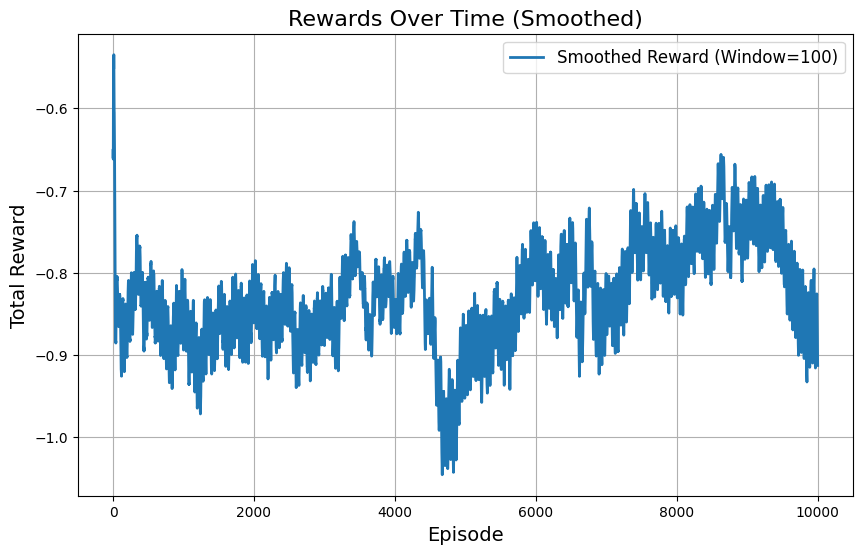

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_rewards_with_moving_average(log_file: str, window_size: int = 100):
    # Read the CSV file into a pandas DataFrame
    data = pd.read_csv(log_file)

    # Calculate the moving average of the rewards
    data["Smoothed Reward"] = data["Total Reward"].rolling(window=window_size, min_periods=1).mean()

    # Plot the original rewards and the smoothed rewards
    plt.figure(figsize=(10, 6))
    plt.plot(data["Episode"], data["Smoothed Reward"], label=f"Smoothed Reward (Window={window_size})", linewidth=2)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Total Reward", fontsize=14)
    plt.title("Rewards Over Time (Smoothed)", fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()

# Usage
log_file = "rewards_log.csv"
plot_rewards_with_moving_average(log_file, window_size=100)

In [ ]:
print(model.policy)

In [7]:
vec_env = model.get_env()
obs = vec_env.reset()
#env.render()
time.sleep(1)
for i in range(44):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    print(action)
    env.render()
    # VecEnv resets automatically
    # if done:
    #   obs = env.reset()

-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]
[[ 0.48009223  0.42281938  0.1434139  -0.44362646 -0.05344471 -0.06052378
  -0.06561777]]
[[ 0.47674346  0.47098064  0.2083028  -0.39974245 -0.07557964  0.09729582
  -0.22493693]]
[[ 0.47995234  0.4688217   0.16994601 -0.38365653 -0.11876112  0.08795327
  -0.17754763]]
[[ 0.4788066   0.47094536  0.09368443 -0.37276363 -0.11284706  0.06032902
  -0.13372287]]
[[ 0.4747858   0.4712476   0.04469925 -0.36073712 -0.09994155  0.04623085
  -0.123155  ]]
[[ 0.47014904  0.47330248  0.01887339 -0.35088807 -0.08203113  0.04012579
  -0.10423511]]
[[ 0.46648514  0.47174066  0.03730029 -0.34335947 -0.12263322  0.02043915
  -0.09024793]]
[[ 0.46778226  0.46996057  0.04384303 -0.34890276 -0.14923674  0.00099319
  -0.0805088 ]]
[[ 0.46528852  0.46773124  0.04753947 -0.34666884 -0.16795558 -0.01295972
  -0.0